In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Load data and prepare text and target
import json

data=json.load(open('../dataset/ydata_3group.json','r'))

In [4]:
text,first_label,all_label=zip(*data)

text=list(text)
first_label=list(first_label)
all_labels=list(all_label)


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

mlb = MultiLabelBinarizer()
Y=mlb.fit_transform(list(all_labels))
# check size of indicator matrix
Y.shape
# check classes
print(mlb.classes_)

np.sum(Y, axis=0)

(4021, 3)

['T1' 'T2' 'T3']


array([1468, 1370, 1337])

In [6]:
# Task 1: K means
from sklearn.feature_extraction.text import TfidfVectorizer

# initialize the TfidfVectorizer 
# set min document frequency to 5

tfidf_vect = TfidfVectorizer(stop_words="english",\
                             min_df=5) 

# generate tfidf matrix
dtm= tfidf_vect.fit_transform(text)


In [9]:
from nltk.cluster import KMeansClusterer, cosine_distance

# set number of clusters
num_clusters=3

clusterer = KMeansClusterer(num_clusters, \
                            cosine_distance, \
                            repeats=10)

# samples are assigned to cluster labels starting from 0
clusters = clusterer.cluster(dtm.toarray(), \
                             assign_clusters=True)


In [10]:
from sklearn import metrics
import numpy as np

centroids=np.array(clusterer.means())

sorted_centroids = centroids.argsort()[:, ::-1] 

voc_lookup= tfidf_vect.get_feature_names()

for i in range(num_clusters):
    
    # get words with top 20 tf-idf weight in the centroid
    top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
    print("Cluster %d: %s " % (i, "; ".join(top_words)))

# Cluster 0: Travel & Transportation
# Cluster 1: Disaster and Accident
# Cluster 2: News and Economy

Cluster 0: said; crash; bus; police; plane; train; passengers; car; cruise; airlines; people; flight; accident; says; road; driver; traffic; airport; city; new 
Cluster 1: said; oil; bp; people; japan; spill; water; gulf; disaster; nuclear; earthquake; pakistan; tsunami; quake; floods; plant; relief; million; government; coast 
Cluster 2: percent; tax; said; year; obama; economy; rate; comment; billion; government; economic; new; budget; debt; bank; growth; rail; market; jobs; spending 


In [11]:

import pandas as pd

df=pd.DataFrame(list(zip(first_label, clusters)), \
                columns=['actual_class','cluster'])
df.head()
pd.crosstab( index=df.cluster, columns=df.actual_class)

,actual_class,cluster
0,T3,0
1,T2,2
2,T2,2
3,T3,0
4,T2,2


actual_class,T1,T2,T3
cluster,,,
0,525,28,999
1,873,17,27
2,70,1299,183


In [12]:
cluster_dict={0:'T3',1:'T1',
              2:"T2"}

# Assign true class to cluster
predicted_target=[cluster_dict[i] \
                  for i in clusters]

print(metrics.classification_report\
      (first_label, predicted_target))

             precision    recall  f1-score   support

         T1       0.95      0.59      0.73      1468
         T2       0.84      0.97      0.90      1344
         T3       0.64      0.83      0.72      1209

avg / total       0.82      0.79      0.78      4021



In [13]:
# Task 2 LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

tf_vectorizer = CountVectorizer(min_df=5, stop_words='english')
tf = tf_vectorizer.fit_transform(text)

tf_feature_names = tf_vectorizer.get_feature_names()

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 3

lda = LatentDirichletAllocation(n_components=num_topics, learning_method='batch',\
                                max_iter=25,verbose=1,
                                evaluate_every=1, n_jobs=1,
                                random_state=0).fit(tf)

iteration: 1 of max_iter: 25, perplexity: 4341.6247
iteration: 2 of max_iter: 25, perplexity: 3810.8042
iteration: 3 of max_iter: 25, perplexity: 3613.4095
iteration: 4 of max_iter: 25, perplexity: 3542.0727
iteration: 5 of max_iter: 25, perplexity: 3510.3360
iteration: 6 of max_iter: 25, perplexity: 3494.6043
iteration: 7 of max_iter: 25, perplexity: 3486.8335
iteration: 8 of max_iter: 25, perplexity: 3482.5631
iteration: 9 of max_iter: 25, perplexity: 3479.9532
iteration: 10 of max_iter: 25, perplexity: 3478.2463
iteration: 11 of max_iter: 25, perplexity: 3477.0911
iteration: 12 of max_iter: 25, perplexity: 3476.2575
iteration: 13 of max_iter: 25, perplexity: 3475.6379
iteration: 14 of max_iter: 25, perplexity: 3475.1612
iteration: 15 of max_iter: 25, perplexity: 3474.7901
iteration: 16 of max_iter: 25, perplexity: 3474.4798
iteration: 17 of max_iter: 25, perplexity: 3474.2084
iteration: 18 of max_iter: 25, perplexity: 3473.9778
iteration: 19 of max_iter: 25, perplexity: 3473.7875
it

In [15]:
num_top_words=20

for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],topic[i]) for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")
    
# Topic 0: Travel and Transportation
# Topic 1: Disaster and Accident
# Topic 3: News and Economy

Topic 0:
[('said', 3539.0633796234201), ('new', 2041.0594602372771), ('com', 1607.3692273173613), ('rail', 1489.2629881205316), ('service', 1220.8009734977018), ('high', 1215.8986156946683), ('crash', 1149.6923926374823), ('passengers', 1119.8685524020075), ('travel', 1116.8351983973748), ('plane', 1077.9233656008594), ('car', 1038.7548279132604), ('speed', 1034.2428201250714), ('city', 1033.3282381225163), ('company', 1002.4494883211619), ('cruise', 1001.3154289700263), ('www', 991.62374239142594), ('information', 964.74371217164867), ('year', 957.94236098751196), ('train', 939.00496241926442), ('state', 926.33282986042229)]


Topic 1:
[('said', 8475.3949501645347), ('people', 3503.5289436974954), ('oil', 2137.3559517343888), ('water', 1589.9122052497851), ('japan', 1496.6949463800054), ('bp', 1384.6165979153297), ('government', 1205.9224282907603), ('disaster', 1168.3205525483907), ('officials', 1153.6937988459797), ('nuclear', 1070.217165778271), ('million', 1033.5365601706901), ('t

In [22]:
# Exercise 5.5. Assign documents to topic
import numpy as np

# Generate topic assignment of each document
topic_assign=lda.transform(tf)

clusters=topic_assign.argmax(axis=1)
# or argsort is also fine

import pandas as pd

df=pd.DataFrame(list(zip(first_label, clusters)), \
                columns=['actual_class','cluster'])
df.head()
pd.crosstab( index=df.cluster, columns=df.actual_class)

[0 2 2 ..., 1 2 0]


,actual_class,cluster
0,T3,0
1,T2,2
2,T2,2
3,T3,0
4,T2,2


actual_class,T1,T2,T3
cluster,,,
0,350,109,1060
1,1033,37,87
2,85,1198,62


In [23]:
cluster_dict={0:'T3',1:'T1',
              2:"T2"}

# Assign true class to cluster
predicted_target=[cluster_dict[i] \
                  for i in clusters]

print(metrics.classification_report\
      (first_label, predicted_target))

# The performance is close

             precision    recall  f1-score   support

         T1       0.89      0.70      0.79      1468
         T2       0.89      0.89      0.89      1344
         T3       0.70      0.88      0.78      1209

avg / total       0.83      0.82      0.82      4021



In [25]:
# Task 3: 
from sklearn.metrics import precision_recall_fscore_support
results=[]

# align topics with ground truth labels
prediction=topic_assign[:, [1,2,0]]

for thresh in np.arange(0, 1, 0.05):
    
    clusters=np.where(prediction>thresh, 1, 0)
    
    precision, recall, fscore, support=\
     precision_recall_fscore_support(\
     Y, clusters)

    results.append(fscore.tolist()+precision.tolist()+recall.tolist())


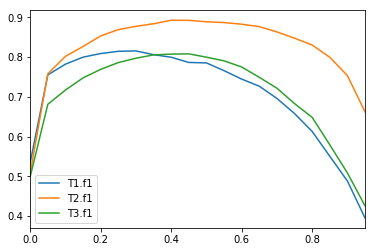

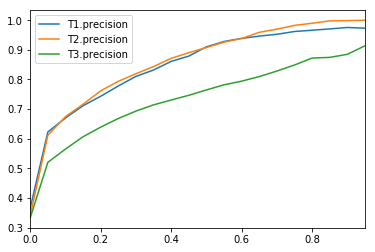

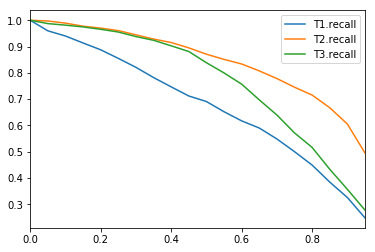

In [26]:
from matplotlib import pyplot as plt
df=pd.DataFrame(results, index=np.arange(0, 1, 0.05), columns=['T1.f1','T2.f1','T3.f1',\
                                                               'T1.precision','T2.precision','T3.precision', \
                                                               'T1.recall','T2.recall','T3.recall'])
df[['T1.f1','T2.f1','T3.f1']].plot()
plt.show()

df[['T1.precision','T2.precision','T3.precision']].plot()
plt.show()

df[['T1.recall','T2.recall','T3.recall']].plot()
plt.show()

# For T1, the best threshold is around 0.3
# For T2, the best threshold is around 0.4
# For T3, the best threshold is around 0.5